# vote_coefficients_0xAA40E2E5c8df03d792A52B5458959C320F86ca18_1


In [1]:
import os
from pathlib import Path
import numpy as np

import pandas as pd

from sbdata.FlipsideApi import FlipsideApi

# Set path to data folder
current_dir = Path(os.getcwd())
PATH_TO_EXPORT = os.path.join(current_dir.parent.parent, 'tx_data', 'all_beta_rounds')
DATA_DIR = os.path.join(current_dir.parent.parent, 'data-regen-rangers')
DATA_DIR_GITCOIN = os.path.join(current_dir.parent.parent, 'data-gitcoin')
CSV_GITCOIN_GRANTS = 'vote_coefficients_0xAA40E2E5c8df03d792A52B5458959C320F86ca18_1.csv'

# read the address from oss grant

api_key = os.environ['FLIPSIDE_API_KEY']
flipside_api = FlipsideApi(api_key, max_address=400)
PATH_TO_VOTES = os.path.join(DATA_DIR, "votes_baoki.csv")
PATH_TO_GRANTS = os.path.join(DATA_DIR, "all-allo-rounds.csv")
PATH_TO_PROJECTS = os.path.join(DATA_DIR, "projects_QmQurt.csv")
PATH_TO_VOTES_GITCOIN = os.path.join(DATA_DIR_GITCOIN, CSV_GITCOIN_GRANTS)

# load data
df_votes = pd.read_csv(PATH_TO_VOTES_GITCOIN)
df_grants = pd.read_csv(PATH_TO_GRANTS)
df_application = pd.read_csv(PATH_TO_PROJECTS)
# Lowercase all addresses because flipside api return lowercase address
#id,projectId,applicationId,roundId,token,voter,grantAddress,amount,amountUSD,coefficient,status,last_score_timestamp,type,success,rawScore,threshold
df_grants['Round ID'] = df_grants['Round ID'].str.lower()
str_columns_votes = ['id', 'projectId', 'roundId', 'voter', 'grantAddress']
df_votes[str_columns_votes] = df_votes[str_columns_votes].applymap(lambda x: x.lower())

str_columns_application = ['id', 'roundId', 'metadata.application.round', 'metadata.application.recipient']
df_application[str_columns_application] = df_application[str_columns_application].applymap(lambda x: str(x).lower())

# round_id = df_grants[df_grants['Round name'] == 'Web3 Community and Education']['Round ID'].values[0]
array_unique_address = df_votes['voter'].unique()

array_unique_address = np.char.lower(array_unique_address.astype(str))


In [2]:
from sbutils import LoadData

# Load data
data_loader = LoadData.LoadData(PATH_TO_EXPORT)
df_tx = data_loader.create_df_tx('ethereum', array_unique_address)

In [3]:
len(array_unique_address)

1012

In [4]:
df_tx.EOA.nunique()

1012

In [5]:
c = np.setxor1d(array_unique_address, df_tx.EOA.values)
c

array([], dtype=object)

## Computing legos booleans

In [6]:
from sblegos.TransactionAnalyser import TransactionAnalyser as txa
tx_analyser = txa(df_tx, df_address=pd.DataFrame(np.intersect1d(df_tx.EOA.unique(), array_unique_address), columns=['address']))

use matching address because some addresses are not in the extracted data set

In [7]:
df_matching_address = pd.DataFrame(df_tx.EOA.unique(), columns=["address"])
df_matching_address.head(2)

,address
0,0x0010e3bce7e7d5890849fa2bb2681174f4352bc4
1,0x00173c4cb23e6d876fcb036ba954a2f9cfcafa19


Compute the boolean 

less than 10 x transaction are not performant legos so we don't use it, has same seed is computed as an intermediarry to get the seed_suspicious flag

In [8]:
df_matching_address['seed_same_naive'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_same_seed_naive(x))
df_matching_address['seed_same'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_same_seed(x))
df_matching_address['seed_suspicious'] = df_matching_address.loc[:, 'seed_same_naive'].ne(df_matching_address.loc[:, 'seed_same'])
df_matching_address['less_5_tx'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_less_than_n_transactions(x, 5))
df_matching_address['less_10_tx'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_less_than_n_transactions(x, 10))
df_matching_address['interacted_other_ctbt'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_interacted_with_other_contributor(x))

In [9]:
df_matching_address['lcs'] = 0
df_matching_address[df_matching_address['less_10_tx'] == True].shape
r = df_matching_address.loc[df_matching_address['less_10_tx'] == True, 'address'].apply(lambda x: tx_analyser.transaction_similitude_pylcs(x, minimum_sim_tx=3))

In [10]:
def lcs_to_array(lcs):
    if lcs.shape[0] == 0:
        return []
    else:
        return np.asarray(lcs.reset_index())

def get_mean_score_lcs(lcs):
    if lcs.shape[0] == 0:
        return 0
    else:
        return lcs.reset_index()['score'].mean()
    
def get_max_score_lcs(lcs):
    if lcs.shape[0] == 0:
        return 0
    else:
        return lcs.reset_index()['score'].max()
    
df_matching_address['cluster_size_lcs'] = 0
df_matching_address['mean_score_lcs'] = 0
df_matching_address['max_score_lcs'] = 0

df_matching_address.loc[df_matching_address['less_10_tx'] == True, 'cluster_size_lcs'] = r.apply(lambda x: len(x))
df_matching_address.loc[df_matching_address['less_10_tx'] == True, 'mean_score_lcs'] = r.apply(lambda x: get_mean_score_lcs(x))
df_matching_address.loc[df_matching_address['less_10_tx'] == True, 'max_score_lcs'] = r.apply(lambda x: get_max_score_lcs(x))

print((df_matching_address[df_matching_address['less_10_tx'] == True]['cluster_size_lcs'] > 0).sum())

171


In [11]:
print(f'Number of voters: {len(df_matching_address)}')

Number of voters: 1012


In [12]:
df_matching_address.sum()

address                  0x0010e3bce7e7d5890849fa2bb2681174f4352bc40x00...
seed_same_naive                                                        602
seed_same                                                              610
seed_suspicious                                                         14
less_5_tx                                                              209
less_10_tx                                                             280
interacted_other_ctbt                                                  207
lcs                                                                      0
cluster_size_lcs                                                       874
mean_score_lcs                                                   33.352381
max_score_lcs                                                    33.352381
dtype: object

### Investigating the boolean seed suspicious

In [13]:
df_matching_address[df_matching_address['seed_suspicious'] == True]

,address,seed_same_naive,seed_same,seed_suspicious,less_5_tx,less_10_tx,interacted_other_ctbt,lcs,cluster_size_lcs,mean_score_lcs,max_score_lcs
19,0x04afa8026bff7e97443f4efd6f96c6f2ff6d4ec9,False,True,True,False,False,True,0,0,0.0,0.0
226,0x3a42f1dcc218b0ee48966954208c9c4acbc04d89,False,True,True,False,False,False,0,0,0.0,0.0
418,0x6b5918d8ef9094679f4b4e1bf397a66ea411b118,False,True,True,False,False,False,0,0,0.0,0.0
504,0x84f1cb27f0822135708aa879bbf04767af18019a,False,True,True,False,False,True,0,0,0.0,0.0
524,0x8a2ec4cc1d731bbace15fc5d234690a0788610a7,True,False,True,True,True,True,0,0,0.0,0.0
574,0x975a0e1bf2fdf3f4e5ba31b6c5774e73573b6b65,False,True,True,False,False,False,0,0,0.0,0.0
577,0x978eb534b26cb8749d352a2c94ec21e659e4248d,True,False,True,False,False,True,0,0,0.0,0.0
601,0x9d5c545d329454ab4ea9ff49a4e77985b9599232,False,True,True,False,False,True,0,0,0.0,0.0
667,0xac4ddaf8fbffba0f1e8c7619720335fd4f03eacd,True,False,True,False,False,True,0,0,0.0,0.0
767,0xc28064b875ae25f9a2ca28c08f116a5c26229f69,False,True,True,False,False,False,0,0,0.0,0.0


In [14]:
# projects_voted = df_votes[df_votes['voter'] == '0xc28064b875ae25f9a2ca28c08f116a5c26229f69']
# print(f'Number of votes {projects_voted.shape[0]} Number of projects voted: {projects_voted.grantAddress.nunique()}')
# # Merge the project the user voted for and the projects 
# projects_voted.merge(df_application, left_on='grantAddress', right_on='metadata.application.recipient', how='left').drop_duplicates(subset='grantAddress').loc[:, ['grantAddress', 'metadata.application.project.title', 'status', 'metadata.application.round']].reset_index(drop=True)

Some of the projects he donated to are in the list of Rejected projects showing that this address is indeed a sybil. And may have contributed to ohter fraudulent projects.

- Pulsar is not very active and is forked code for the most part
- Fusion not very active on github but has a lot of activity on twitter 
- Share suspicious Github with no activity, twitter does not exists: suspicious

Other projects are ok

In [15]:
# projects_voted = df_votes[df_votes['voter'] == '0x61ffe691821291d02e9ba5d33098adcee71a3a17']
# print(f'Number of votes {projects_voted.shape[0]} Number of projects voted: {projects_voted.grantAddress.nunique()}')
# # Merge the project the user voted for and the projects 
# projects_voted.merge(df_application, left_on='grantAddress', right_on='metadata.application.recipient', how='left').drop_duplicates(subset='grantAddress').loc[:, ['grantAddress', 'metadata.application.project.title']].reset_index(drop=True)

In [16]:
# projects_voted = df_votes[df_votes['voter'] == '0xe51200a4d161935fc311ed8a0401feb1abf20e3a']
# print(f'Number of votes {projects_voted.shape[0]} Number of projects voted: {projects_voted.grantAddress.nunique()}')
# # Merge the project the user voted for and the projects 
# projects_voted.merge(df_application, left_on='grantAddress', right_on='metadata.application.recipient', how='left').drop_duplicates(subset='grantAddress').loc[:, ['grantAddress', 'metadata.application.project.title']].reset_index(drop=True)

The boolean seed suspicious is not relevant for that round we will not use it for the analysis.

### Computing the new dex interaction score
It was investigated in another notebook 

In [17]:
def get_interacted_address(from_address, to_address, address):
    if from_address == address:
        return to_address
    else:
        return from_address

def count_interaction_with_any(tx_analyser, address, array_address):
    """
    Return an integer of the number of interactions with the addresses in the array_address
    Parameters
    ----------
    address : str
        The address to check

    Returns
    -------
    count_interaction_with_any : int
        The number of interactions with the addresses in the array_address
    """
    tx_analyser.set_group_by_sorted_EOA()

    df = tx_analyser.gb_EOA_sorted.get_group(address)
    address_interacted = df.apply(lambda x: get_interacted_address(x['from_address'], x['to_address'], address), axis=1)
    tx_boolean_interacted = address_interacted.isin(array_address)
    return tx_boolean_interacted.sum()

def has_interacted_with_any(tx_analyser, address, array_address):
    """
    Return a boolean whether the address has interacted with any address in the array_address
    Parameters
    ----------
    address : str
        The address to check

    Returns
    -------
    has_interacted_with_any : bool
        True if the address has interacted with one or more of the addresses in the array_address
    """
    count_interaction_with_any = count_interaction_with_any(tx_analyser, address, array_address)
    return count_interaction_with_any > 0

In [18]:
label_query = '''
SELECT ADDRESS, CREATOR, LABEL_TYPE, ADDRESS_NAME, PROJECT_NAME
FROM crosschain.core.address_labels 
WHERE BLOCKCHAIN='ethereum'
AND LABEL_SUBTYPE = 'pool' 
;'''
df_label = flipside_api.execute_query(label_query)

In [19]:
# extract all the pool addresses
array_pool_address = df_label['address'].unique()

In [20]:
tx_analyser.set_group_by_sorted_EOA()

In [21]:
# Compute the number of interactions with any of the pools for each address
df_matching_address['count_interaction_with_pool'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, array_pool_address))

In [22]:
(df_matching_address['count_interaction_with_pool'] > 0).sum() / len(df_matching_address)

0.3290513833992095

In [23]:
label_query = '''
SELECT DISTINCT(LABEL_SUBTYPE)
FROM crosschain.core.address_labels 
WHERE BLOCKCHAIN='ethereum'
;'''
df_distinct_labels = flipside_api.execute_query(label_query)

In [24]:
df_distinct_labels.label_subtype.unique()

array(['nf_token_contract', 'token_distribution', 'nf_position_manager',
       'router', 'marketplace', 'foundation', 'strategy', 'fee_wallet',
       'multisig', 'airdrop_contract', 'governance', 'contract_deployer',
       'reserve', 'chadmin', 'token_contract', 'bridge', 'mint_burn',
       'mint_contract', 'mining_pool', 'donation_address', 'pool',
       'hot_wallet', 'deposit_wallet', 'staking_contract', 'oracle',
       'vault', 'toxic', 'cold_wallet', 'swap_router', 'voting',
       'general_contract', 'distributor_cex', 'rewards', 'dao',
       'treasury', 'token_sale', 'aggregator_contract', 'escrow',
       'swap_contract'], dtype=object)

From these tags lets flag any address that have interacted with a toxic wallet

In [25]:
label_query = '''
SELECT ADDRESS, CREATOR, LABEL_TYPE, ADDRESS_NAME, PROJECT_NAME
FROM crosschain.core.address_labels 
WHERE BLOCKCHAIN='ethereum'
AND LABEL_SUBTYPE = 'toxic'
;'''
df_toxic = flipside_api.execute_query(label_query)

In [26]:
df_toxic.shape

(4857, 6)

In [27]:
# Compute the number of interactions with any of the scam for each address
df_matching_address['count_interaction_with_toxic'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, df_toxic['address'].unique()))

In [28]:
print(f'Percentage of addresses that have interacted with a toxic address: {int((df_matching_address["count_interaction_with_toxic"] > 0).sum() / len(df_matching_address) *100)}%')

Percentage of addresses that have interacted with a toxic address: 1%


In [29]:
tag_query = '''
SELECT DISTINCT(TAG_TYPE)
FROM crosschain.core.address_tags 
WHERE BLOCKCHAIN='ethereum'
;'''
df_distinct_tags = flipside_api.execute_query(tag_query)

In [30]:
df_distinct_tags.tag_type.values

array(['contract', 'Aave Delegates', 'NFT', 'cex', 'Balancer Delegates',
       'chainlink oracle', 'dex', 'nft', 'dydx delegate', 'wallet',
       'activity'], dtype=object)

I found the tag_name "airdrop master" could be interesting 

In [31]:
query_airdrop_master = '''
SELECT BLOCKCHAIN, CREATOR, ADDRESS, TAG_NAME
FROM crosschain.core.address_tags 
WHERE BLOCKCHAIN='ethereum'
AND TAG_NAME = 'airdrop master'
;
'''
df_airdrop_master = flipside_api.execute_query(query_airdrop_master)

In [32]:
# Compute the number of interactions with any of the aidrop for each address
df_matching_address['count_interaction_with_airdrop_m'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, df_airdrop_master['address'].unique()))
print(f'Percentage of addresses that interacted with airdrop master: {int((df_matching_address["count_interaction_with_airdrop_m"] > 0).sum() / len(df_matching_address) * 100)}%')

Percentage of addresses that interacted with airdrop master: 19%


In [33]:
# Boolean whether the address is a aidrop master
df_matching_address['is_airdrop_master'] = df_matching_address['address'].apply(lambda x: x in df_airdrop_master['address'].unique()) 
print(f'Percentage of addresses that are airdrop master: {int((df_matching_address["is_airdrop_master"]).sum() / len(df_matching_address) * 100)}%')

Percentage of addresses that are airdrop master: 6%


In [34]:
sql_query_tornado = '''
SELECT DISTINCT PROJECT_NAME, ADDRESS
FROM crosschain.core.address_labels 
WHERE BLOCKCHAIN='ethereum'
AND PROJECT_NAME LIKE '%tornado%'
;
'''
df_tornado = flipside_api.execute_query(sql_query_tornado)

In [35]:
# Count the number of interactions with tornado
df_matching_address['count_interaction_with_tornado'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, df_tornado['address'].unique()))
print(f'Percentage of addresses that interacted with tornado: {int((df_matching_address["count_interaction_with_tornado"] > 0).sum() / len(df_matching_address) * 100)}%')

Percentage of addresses that interacted with tornado: 3%


In [36]:
# Count the number of time the address interatec with disperse contract: '0xD152f549545093347A162Dce210e7293f1452150'
df_matching_address['count_interaction_with_disperse'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, [str.lower('0xD152f549545093347A162Dce210e7293f1452150')]))
print(f'Percentage of addresses that interacted with disperse: {int((df_matching_address["count_interaction_with_disperse"] > 0).sum() / len(df_matching_address) * 100)}%')

Percentage of addresses that interacted with disperse: 1%


In [37]:
df_matching_address.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

,lcs,cluster_size_lcs,mean_score_lcs,max_score_lcs,count_interaction_with_pool,count_interaction_with_toxic,count_interaction_with_airdrop_m,count_interaction_with_tornado,count_interaction_with_disperse
count,1012.0,1012.000000,1012.000000,1012.000000,1012.000000,1012.000000,1012.000000,1012.000000,1012.000000
mean,0.0,0.863636,0.032957,0.032957,7.380435,0.025692,1.863636,0.105731,0.092885
std,0.0,2.446092,0.073515,0.073515,39.085371,0.233944,8.208773,0.839013,1.116936
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.0,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
90%,0.0,3.900000,0.200000,0.200000,13.000000,0.000000,3.000000,0.000000,0.000000
max,0.0,14.000000,0.200000,0.200000,745.000000,5.000000,96.000000,18.000000,24.000000


In [38]:
df_matching_address['has_interaction_toxic'] = df_matching_address['count_interaction_with_toxic'] > 0
df_matching_address['has_no_pool_interaction'] = df_matching_address['count_interaction_with_pool'] < 6
df_matching_address['has_interaction_airdrop_m'] = df_matching_address['count_interaction_with_airdrop_m'] > 0
df_matching_address['has_interaction_tornado'] = df_matching_address['count_interaction_with_tornado'] > 0
df_matching_address['has_interaction_disperse'] = df_matching_address['count_interaction_with_disperse'] > 0

In [39]:
boolean_features = ['seed_suspicious', 'has_interaction_toxic', 'has_no_pool_interaction', 'has_interaction_airdrop_m', 'has_interaction_tornado', 'has_interaction_disperse', 'is_airdrop_master', 'interacted_other_ctbt']

In [40]:
df_matching_address[boolean_features].sum() 

seed_suspicious               14
has_interaction_toxic         18
has_no_pool_interaction      856
has_interaction_airdrop_m    201
has_interaction_tornado       32
has_interaction_disperse      17
is_airdrop_master             70
interacted_other_ctbt        207
dtype: int64

In [41]:
len(df_matching_address)

1012

In [42]:
(df_matching_address[boolean_features].sum(axis=1) > 2).sum()

93

In [43]:
df_matching_address['count_flags'] = df_matching_address[boolean_features].sum(axis=1)

In [44]:
df_matching_address['suspicious_1'] = df_matching_address['count_flags'] > 2

In [45]:
df_suspicious_1 = df_matching_address[df_matching_address['suspicious_1'] == True]

### Investigating the grants receiving the most votes from the flagged addresses

In [46]:
df_vote_sus1 = df_votes[df_votes['voter'].isin(df_suspicious_1['address'])]
count_unique_vote_grant = df_votes.drop_duplicates(subset=['grantAddress', 'voter']).groupby('grantAddress')['id'].count().sort_values(ascending=False).reset_index()
count_suspicious_vote_grant = df_vote_sus1['grantAddress'].value_counts().reset_index()
df_vote_grant = count_unique_vote_grant.merge(count_suspicious_vote_grant, left_on='grantAddress', right_on='grantAddress', how='left').fillna(0).rename(columns={'id': 'count_unique_vote', 'count': 'count_suspicious_vote'})

In [47]:
df_vote_grant['percentage_suspicious_vote'] = df_vote_grant['count_suspicious_vote'] / df_vote_grant['count_unique_vote'] * 100
print(f'Number of suspicious votes {df_vote_sus1.shape[0]} Number of projects voted: {df_vote_sus1.grantAddress.nunique()}')
# Merge the project the user voted for and the projects 
gr_sus = df_vote_grant.merge(df_application, left_on='grantAddress', right_on='metadata.application.recipient', how='left').drop_duplicates(subset='grantAddress').loc[:, ['grantAddress', 'metadata.application.project.title', 'percentage_suspicious_vote', 'count_suspicious_vote', 'roundId', 'status']].reset_index(drop=True).sort_values(by='percentage_suspicious_vote', ascending=False)
print(f'number of grants: {gr_sus.shape[0]}')
gr_sus.head(30)

Number of suspicious votes 430 Number of projects voted: 140
number of grants: 216


,grantAddress,metadata.application.project.title,percentage_suspicious_vote,count_suspicious_vote,roundId,status
149,0xf163d77b8efc151757fecba3d463f3bac7a4d808,Today in DeFi,60.000000,3.0,0xaa40e2e5c8df03d792a52b5458959c320f86ca18,APPROVED
62,0x5ead82e959d8218f6003526ab8d457972b679c41,Ethereum Costa Rica,57.142857,8.0,0xaa40e2e5c8df03d792a52b5458959c320f86ca18,APPROVED
111,0x09a24d78a828f6c651a3a073b4365771465dd57a,EthCartagena,55.555556,5.0,0xaa40e2e5c8df03d792a52b5458959c320f86ca18,APPROVED
9,0x4adc8cc149a03f44386bee80bab36f9e8022b195,Unitap,51.515152,17.0,0xaa40e2e5c8df03d792a52b5458959c320f86ca18,APPROVED
200,0x1c8a540dc686d0e30063d0c69c55958558e27656,Meet Crypto,50.000000,1.0,0xaa40e2e5c8df03d792a52b5458959c320f86ca18,APPROVED
193,0x87678f9229910d5462ee26df6f7b4cf41888638c,LifeShip | Decentralized space capsules,50.000000,1.0,0xaa40e2e5c8df03d792a52b5458959c320f86ca18,APPROVED
198,0x459efd5f53b4bb04b278925754fd427783831bc5,Web3Domains.com,50.000000,1.0,0xaa40e2e5c8df03d792a52b5458959c320f86ca18,APPROVED
166,0x8d576f8c78ffa2dec7ada30dc516fbd35d9a8972,Andino,50.000000,2.0,0xaa40e2e5c8df03d792a52b5458959c320f86ca18,APPROVED
202,0xe23e0cccc91b11b3fe2d3dd140e28b598e395289,Buidlers,50.000000,1.0,0xaa40e2e5c8df03d792a52b5458959c320f86ca18,APPROVED
105,0xbd0cce3fefb1848af6db5f9523945862da2bdd7c,Camp Decentral,44.444444,4.0,0xaa40e2e5c8df03d792a52b5458959c320f86ca18,APPROVED


### Look at the addresses with at least one flag

We are going to review the addresses that have at least 1 flag:
- has_intercation_toxic 
- has_interaction_disperse
- has_interaction_airdrop_master
- is airdrop master
- seed suspicious
- interacted with other contributor and less than 5 tx

I decided to remove tornado cash because someone can be anonimous with out being a sybil

In [48]:
df_matching_address['interact_less_5tx'] = np.logical_and(df_matching_address['interacted_other_ctbt'], df_matching_address['less_5_tx'])

In [49]:
interaction_bool = ['has_interaction_toxic', 'has_interaction_airdrop_m', 'has_interaction_disperse', 'is_airdrop_master', 'seed_suspicious', 'interact_less_5tx']

In [50]:
df_matching_address[interaction_bool].sum()

has_interaction_toxic         18
has_interaction_airdrop_m    201
has_interaction_disperse      17
is_airdrop_master             70
seed_suspicious               14
interact_less_5tx             16
dtype: int64

In [51]:
from scipy.spatial.distance import pdist

def jaccard_similarity_matrix(df):
    
    n = df.shape[1]
    scores = 1 - pdist(np.array(df).T, metric='jaccard')
    result = np.zeros((n,n))
    result[np.triu_indices(n, k=1)] = scores
    result += result.T
    np.fill_diagonal(result, 1)
    return pd.DataFrame(result, index=df.columns, columns=df.columns)

jaccard_similarity = jaccard_similarity_matrix(df_matching_address[interaction_bool])
jaccard_similarity

,has_interaction_toxic,has_interaction_airdrop_m,has_interaction_disperse,is_airdrop_master,seed_suspicious,interact_less_5tx
has_interaction_toxic,1.000000,0.057971,0.060606,0.060241,0.000000,0.000000
has_interaction_airdrop_m,0.057971,1.000000,0.068627,0.278302,0.000000,0.009302
has_interaction_disperse,0.060606,0.068627,1.000000,0.074074,0.000000,0.000000
is_airdrop_master,0.060241,0.278302,0.074074,1.000000,0.012048,0.000000
seed_suspicious,0.000000,0.000000,0.000000,0.012048,1.000000,0.034483
interact_less_5tx,0.000000,0.009302,0.000000,0.000000,0.034483,1.000000


<Axes: >

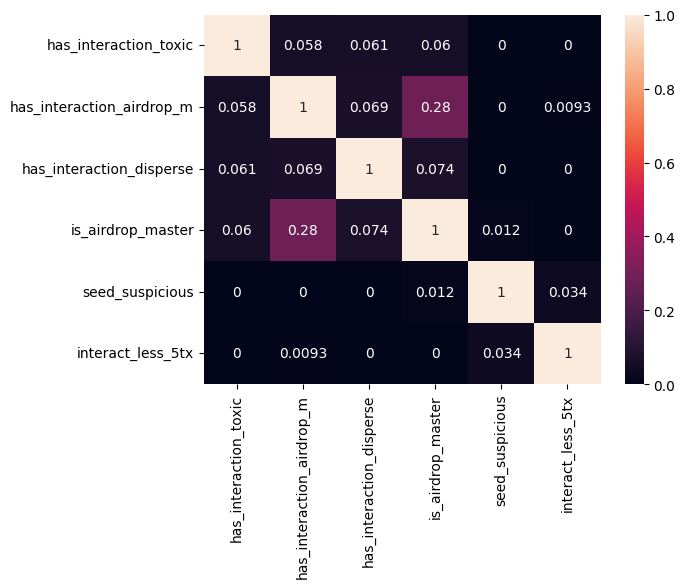

In [52]:
import seaborn as sns
sns.heatmap(jaccard_similarity, annot=True)

In [53]:
df_matching_address['flagged'] = df_matching_address[interaction_bool].sum(axis=1) > 0
df_interact_sus_2 = df_matching_address[df_matching_address['flagged'] == True]
print(f'Number of addresses that interacted with a suspicious contract or address: {df_interact_sus_2.shape[0]}')

Number of addresses that interacted with a suspicious contract or address: 247


In [54]:
df_vote_sus_2 = df_votes[df_votes['voter'].isin(df_interact_sus_2['address'])]
# count_unique_vote_grant = df_votes.drop_duplicates(subset=['grantAddress', 'voter']).groupby('grantAddress')['id'].count().sort_values(ascending=False).reset_index().head(10)
count_suspicious_vote_grant_2 = df_vote_sus_2['grantAddress'].value_counts().reset_index()
df_vote_grant_2 = count_unique_vote_grant.merge(count_suspicious_vote_grant_2, left_on='grantAddress', right_on='grantAddress', how='left').fillna(0).rename(columns={'id': 'count_unique_vote', 'count': 'count_suspicious_vote'})

In [55]:
df_vote_grant_2['percentage_suspicious_vote'] = df_vote_grant_2['count_suspicious_vote'] / df_vote_grant_2['count_unique_vote'] * 100
print(f'Number of suspicious votes {df_vote_sus_2.shape[0]} Number of projects voted: {df_vote_sus_2.grantAddress.nunique()}')
# Merge the project the user voted for and the projects 
gr_sus_2 = df_vote_grant_2.merge(df_application, left_on='grantAddress', right_on='metadata.application.recipient', how='left').drop_duplicates(subset='grantAddress').loc[:, ['grantAddress', 'metadata.application.project.title', 'percentage_suspicious_vote', 'count_suspicious_vote', 'roundId', 'status']].reset_index(drop=True).sort_values(by='percentage_suspicious_vote', ascending=False)
print(f'number of grants: {gr_sus.shape[0]}')
gr_sus_2.head(30)

Number of suspicious votes 1010 Number of projects voted: 194
number of grants: 216


,grantAddress,metadata.application.project.title,percentage_suspicious_vote,count_suspicious_vote,roundId,status
207,0xd6a6b5bac1e2eac575b1b1bc066d9d6e384d7e50,Dot.alert(),150.000000,3.0,0xaa40e2e5c8df03d792a52b5458959c320f86ca18,APPROVED
183,0xac9844ec536b69e826ff643520a2d185d13c52ed,WGMI Community DAO,133.333333,4.0,0xaa40e2e5c8df03d792a52b5458959c320f86ca18,APPROVED
215,0x557a13655a955e50fa5b7f8128b9414d15ee399e,American Crypto Academy,100.000000,1.0,0xaa40e2e5c8df03d792a52b5458959c320f86ca18,APPROVED
91,0xa1e9f3215590e27b18b48f1ebf785f031c22d272,MetaFest,100.000000,11.0,0xaa40e2e5c8df03d792a52b5458959c320f86ca18,APPROVED
211,0x2a58a4ad067ea8bd71fb7cb5b7b6db775d7c60a1,Konma Upskill,100.000000,1.0,0xaa40e2e5c8df03d792a52b5458959c320f86ca18,APPROVED
210,0xad851ef1ad2ccf8f87413e6c274bccbec37469d2,DspytDAO - Fostering Innovation and Education ...,100.000000,1.0,0xaa40e2e5c8df03d792a52b5458959c320f86ca18,APPROVED
193,0x87678f9229910d5462ee26df6f7b4cf41888638c,LifeShip | Decentralized space capsules,100.000000,2.0,0xaa40e2e5c8df03d792a52b5458959c320f86ca18,APPROVED
209,0xcfa8f21be8f6347703f7c9e45b3e3c08aaa5893e,DuaCrypto: The Premier Ethereum YouTube Channel,100.000000,1.0,0xaa40e2e5c8df03d792a52b5458959c320f86ca18,APPROVED
214,0xb5759de539114751ca6db8d967ad21913df25ecf,Cryptoblarabi Academy,100.000000,1.0,0xaa40e2e5c8df03d792a52b5458959c320f86ca18,APPROVED
194,0x41d2a18e1ddacdabfddadb62e9aee67c63070b76,Learning Data Science on the Ethereum Blockcha...,100.000000,2.0,0xaa40e2e5c8df03d792a52b5458959c320f86ca18,APPROVED


In [56]:
boolean_to_keep = ['seed_suspicious', 'has_interaction_toxic', 'has_no_pool_interaction', 'has_interaction_tornado', 'has_interaction_disperse', 'is_airdrop_master', 'has_interaction_airdrop_m', 'interacted_other_ctbt', 'interact_less_5tx', 'flagged']

In [57]:
df_matching_address[boolean_to_keep].sum()

seed_suspicious               14
has_interaction_toxic         18
has_no_pool_interaction      856
has_interaction_tornado       32
has_interaction_disperse      17
is_airdrop_master             70
has_interaction_airdrop_m    201
interacted_other_ctbt        207
interact_less_5tx             16
flagged                      247
dtype: int64

In [58]:
final_merge = df_votes.merge(df_matching_address[boolean_to_keep + ['address']], left_on='voter', right_on='address', how='left')
print(f'number of squelched votes out of {final_merge.shape[0]}')
final_merge.shape[0] - final_merge[['coefficient']].sum() 

number of squelched votes out of 2876


coefficient    400
dtype: int64

In [59]:
print(df_votes.shape)
print(final_merge.shape)

(2876, 16)
(2876, 27)


C:\Users\DELL Admin\AppData\Local\Temp\ipykernel_23448\2681738413.py:7: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_votes_stephi = pd.read_csv(os.path.join(DATA_DIR_STEFI, CSV_STEPHI))


(81811, 19) votes stephi
(2876, 27) final merge
(2876, 29) votes merge


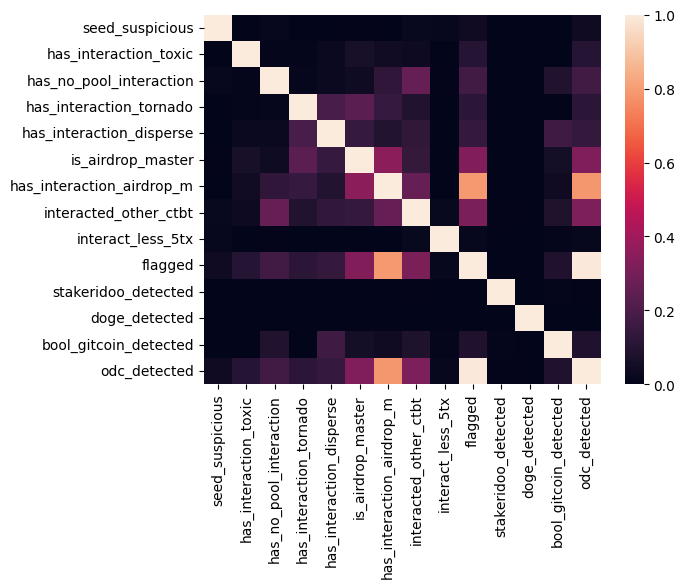

In [60]:
# Adding Stakeriddo and Gray flagged wallet

DATA_DIR_STEFI = os.path.join(current_dir.parent.parent, 'stefi')
CSV_STEPHI = 'sso_odc_analysis.csv'

# load data
df_votes_stephi = pd.read_csv(os.path.join(DATA_DIR_STEFI, CSV_STEPHI))
print(f'{df_votes_stephi.shape} votes stephi')
print(f'{final_merge.shape} final merge')
df_stephi_bool_voter = df_votes_stephi[['voter', 'stakeridoo_detected', 'doge_detected']]
df_merge = final_merge.merge(df_stephi_bool_voter.drop_duplicates(subset=['voter']), left_on='voter', right_on='voter', how='left')
print(f'{df_merge.shape} votes merge')

df_merge['bool_gitcoin_detected'] = np.logical_not(df_merge.success.astype(bool))
df_merge['stakeridoo_detected'].fillna(False, inplace=True)
df_merge['doge_detected'].fillna(False, inplace=True)
df_merge['odc_detected'] = np.logical_or(np.logical_or(df_merge['stakeridoo_detected'], df_merge['doge_detected']), df_merge['flagged'])

boolean_jaccard = boolean_to_keep + ['stakeridoo_detected', 'doge_detected', 'bool_gitcoin_detected', 'odc_detected']
jaccard_similarity_2 = jaccard_similarity_matrix(df_merge[boolean_jaccard])
sns.heatmap(jaccard_similarity_2)

df_merge['proposed_coeff'] = np.logical_not(np.logical_or(df_merge['odc_detected'], df_merge['bool_gitcoin_detected']))

df_merge.drop(columns=['bool_gitcoin_detected', 'address']).to_csv(f'../output_gitcoin/n_{CSV_GITCOIN_GRANTS}', index=False)

In [61]:
df_merge[boolean_jaccard].sum(axis=0)

seed_suspicious                40
has_interaction_toxic         101
has_no_pool_interaction      2219
has_interaction_tornado       128
has_interaction_disperse      142
is_airdrop_master             328
has_interaction_airdrop_m     800
interacted_other_ctbt         804
interact_less_5tx              16
flagged                      1010
stakeridoo_detected             6
doge_detected                   0
bool_gitcoin_detected         234
odc_detected                 1014
dtype: int64